In [1]:
import pandas as pd
import sys
import os
import numpy as np
import signatureanalyzer as sa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../funcs")

from features import snvs, deletions, amplifications, translocations, hyperdiploidy, trisomies
from features import filt_snvs
from features import pathways, biallelic, myc, patient_metadata, clinical_metadata
import smm_utils as smm
import plot as pl

/home/sanand/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


---
# Clustering SMM Patients

This notebook contains code to generate all components of Figure 1 and related supplemental figures & tables. This notebook is focused on clustering of binarized genomic features from WES & targeted seq of n=214 Smoldering Multiple Myeloma (SMM) patients.

**Author**: [Shankara Anand](sanand@broadinstitute.org)

In [2]:
PLOTS_DIR = "figures"
os.makedirs(PLOTS_DIR, exist_ok=True)

SUPP_DIR = "supplement"
os.makedirs(SUPP_DIR, exist_ok=True)

In [3]:
SMM_DATA = "../data/raw/SMM_study_final_list_for_clustering.txt"
N_MIN_FEAT = 2

---

## 1. Load Raw Data

Filter and process based on features annotated in `../funcs/features.py`.

In [4]:
df = pd.read_csv(SMM_DATA, sep='\t').set_index("Sample ID")

numerical_entries = (snvs, deletions, amplifications, translocations, hyperdiploidy)
metadata_entries = (patient_metadata, pathways, clinical_metadata)

num_set = [i for sub in numerical_entries for i in sub]
meta_set = [i for sub in metadata_entries for i in sub]

#### Save Processed Files

In [15]:
# Raw numerical entries matrix
X = df[num_set].fillna(0).astype(int)
X.to_csv(os.path.join(SUPP_DIR, "table1_numerical_entries.tsv"), sep='\t')

# Metadata
meta = df[meta_set]
meta.to_csv(os.path.join(SUPP_DIR, "table2_cohort_metadata.tsv"), sep='\t')

# Filter for binarized features with atleast N_MIN_FEAT in cohort
X_filt = X.loc[:,X.sum(0)>N_MIN_FEAT]
print("{} / {} (v1 - all SNVs) features used for clustering.".format(X_filt.shape[1], X.shape[1]))
X_filt.to_csv(os.path.join(SUPP_DIR, "table3_smm_filt_matrix.tsv"), sep='\t')

# Filter for binarized features with atleast N_MIN_FEAT in cohort - with KNOWN SNVs
numerical_entries_2 = (filt_snvs, deletions, amplifications, translocations, hyperdiploidy)
num_set_2 = [i for sub in numerical_entries_2 for i in sub]

X_2 = df[num_set_2].fillna(0).astype(int)
X_2_filt = X_2.loc[:,X_2.sum(0)>N_MIN_FEAT]
print("{} / {} (v2 - known SNVs) features used for  clustering.".format(X_2_filt.shape[1], X_2.shape[1]))
X_2_filt.to_csv(os.path.join(SUPP_DIR, "table3a_smm_filt_v2_matrix.tsv"), sep='\t')

48 / 80 (v1 - all SNVs) features used for clustering.
41 / 56 (v2 - known SNVs) features used for  clustering.


---

## 2. Logistic PCA

* Run:

`Rscript ../funcs/logisticPCA.R -i supplement/table3a_smm_filt_v2_matrix.tsv -o supplement`

* This performs a logistic variant of PCA for binary data. For more details, see:
https://arxiv.org/abs/1510.06112

In [5]:
LOG_PCA = os.path.join(SUPP_DIR, "logistic_pca.tsv")
METADATA = os.path.join(SUPP_DIR, "table2_cohort_metadata.tsv")

In [6]:
# Load Matrices
X = pd.read_csv(os.path.join(SUPP_DIR, "table1_numerical_entries.tsv"), sep='\t', index_col=0)
X_filt = pd.read_csv(os.path.join(SUPP_DIR, "table3_smm_filt_matrix.tsv"), sep='\t', index_col=0)
X_2_filt = pd.read_csv(os.path.join(SUPP_DIR, "table3a_smm_filt_v2_matrix.tsv"),sep='\t',index_col=0)

# Load Cohort Metadata + Logistic PCA Results
meta_df = pd.read_csv(METADATA, sep='\t',index_col=0)
logpca_df = pd.read_csv(LOG_PCA, sep='\t').rename(columns={'V1':'PC1','V2':'PC2'})
logpca_df.index = meta_df.index
meta_df = meta_df.join(logpca_df)

# Add Cohort
def add_cohort(x):
    if x=='Janssen':
        return 'Janssen'
    else:
        return 'DFCI'
meta_df['cohort'] = meta_df['Sequencing'].apply(add_cohort)

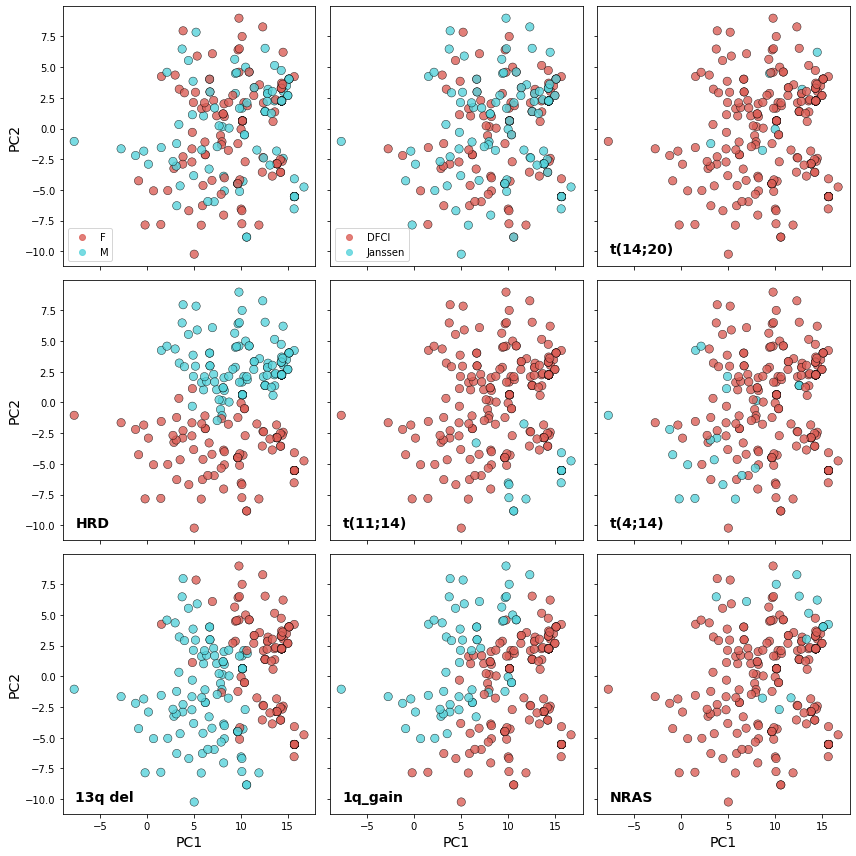

In [7]:
fig,axes = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)

pl.plot_scatter(meta_df, 'SEX', axes[0,0])
pl.plot_scatter(meta_df, 'cohort', axes[0,1])
pl.plot_scatter(meta_df.join(X_filt['t(14;20)']), 't(14;20)', axes[0,2])

pl.plot_scatter(meta_df.join(X_filt['HRD']), 'HRD', axes[1,0])
pl.plot_scatter(meta_df.join(X_filt['t(11;14)']), 't(11;14)', axes[1,1])
pl.plot_scatter(meta_df.join(X_filt['t(4;14)']), 't(4;14)', axes[1,2])

pl.plot_scatter(meta_df.join(X_filt['13q del']), '13q del', axes[2,0])
pl.plot_scatter(meta_df.join(X_filt['1q_gain']), '1q_gain', axes[2,1])
pl.plot_scatter(meta_df.join(X_filt['NRAS']), 'NRAS', axes[2,2])

axes[0,2].legend().remove()
axes[1,0].legend().remove()
axes[1,1].legend().remove()
axes[1,2].legend().remove()
axes[2,0].legend().remove()
axes[2,1].legend().remove()
axes[2,2].legend().remove()

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[2,1].set_ylabel("")
axes[0,2].set_ylabel("")
axes[1,2].set_ylabel("")
axes[2,2].set_ylabel("")

axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,2].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")
axes[1,2].set_xlabel("")

axes[0,0].set_title("")
axes[0,1].set_title("")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "figS1a_lpca_grid.pdf"), dpi=100, bbox_inches='tight')

---

## 3. Binary Matrix Factorization

#### Single Solution Binary Matrix Factorization

* One run with fixed rank (`K` = 6)
* Demonstrates factorization approach may be feasible

In [8]:
H, W, _, _ = smm.bnmf(X_2_filt.T, K=6, n_run=50, seed='nndsvd')
markers, signatures = sa.utils.select_markers(X_filt.T, W, H, cut_norm=0.1, cut_diff=.1)

# H.to_csv(os.path.join(SUPP_DIR, "H_bnmf_k6.tsv"), sep='\t')
# W.to_csv(os.path.join(SUPP_DIR, "W_bnmf_k6.tsv"), sep='\t')

Text(0.05, 1.0, '')

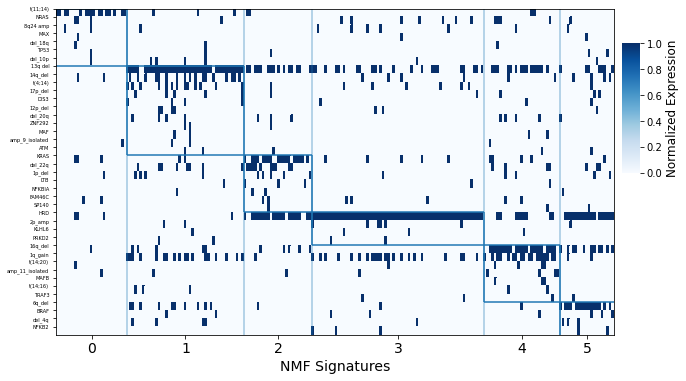

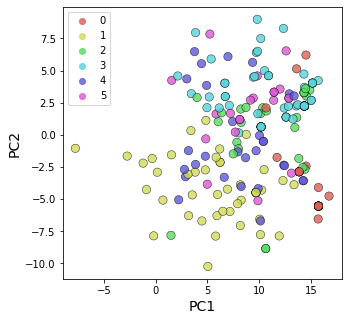

In [9]:
_ = sa.pl.marker_heatmap(
    X_filt.T,
    signatures,
    H['max_id'],
    diff=0,
    max_norm=0.1,
    display_y=True,
    figsize=(10,6),
    y_hm_label='',
    cmap='Blues'
)
#plt.savefig(os.path.join(PLOTS_DIR, "bnmf_k6.pdf"), dpi=100, bbox_inches='tight')

fig,ax = plt.subplots(figsize=(5,5))
pl.plot_scatter(meta_df.join(H['max_id']), 'max_id',ax)
ax.legend(loc='upper left')
ax.set_title("")
#plt.savefig(os.path.join(PLOTS_DIR, "bnmf_k6_pca.pdf"), dpi=100, bbox_inches='tight')

---

## 4. Consensus Clustering

* We perform binary matrix factorization for a rank K=4 to K=10 on filtered input matrix
    * Uses _known_ SNVs for multiple myeloma (filt v2)
* Aggregate results to find cluster membership matrix
* Choose appropriate heirarchy (K=6)
    * We systematically determine this using downsampling analysis; run the following script:
    
`python ../funcs/downsampling_analysis.py -i supplement/table3a_smm_filt_v2_matrix.tsv -o supplement/downsampling -p figures`
    
* Identify significant features using fisher exact

In [10]:
# Run Binary Matrix Factorization for K=4 to K=10
H_matrices = list()

for K in tqdm(range(4,11)):
    H, _, _, _ = smm.bnmf(X_2_filt.T, K=K, n_run=50, seed='nndsvd')
    H_matrices.append(H)
    
# Build consensus matrix
cmatrix, assign_p = smm.consensus_cluster(H_matrices)

100%|██████████| 7/7 [00:20<00:00,  2.93s/it]


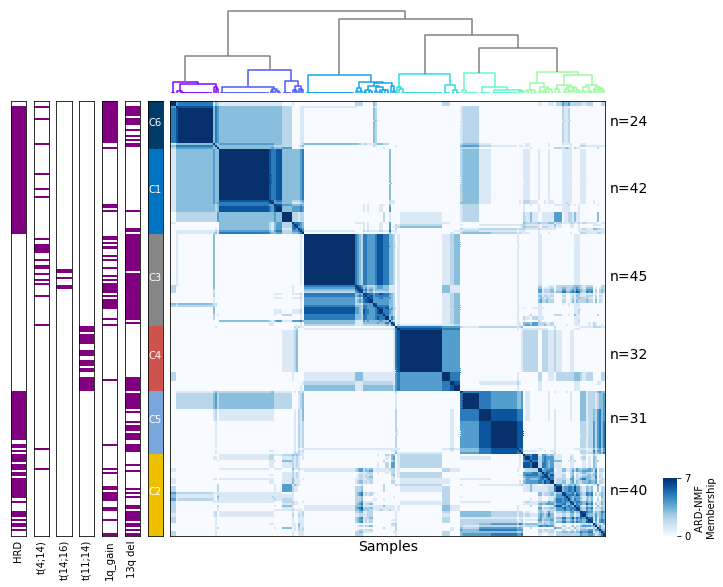

In [11]:
_, cluster_val = pl.plot_consensus_matrix(
    cmatrix,
    n_clusters=6,
    metas=['aggr']+[X[x].replace(0,np.nan) for x in X if x in ("t(11;14)", "t(14;16)", "t(4;14)", "HRD", "1q_gain", "13q del")],
    cmap='Blues'
)

plt.savefig(os.path.join(PLOTS_DIR, "figS1b_bmf_consensus_k6.pdf"), dpi=100, bbox_inches='tight')

In [12]:
meta_df = meta_df.join(cluster_val)

# Rename
meta_df['consensus_nmf'] = meta_df['clusters']+1
meta_df['consensus_nmf'] = meta_df['consensus_nmf'].apply(lambda x: "C"+str(x))

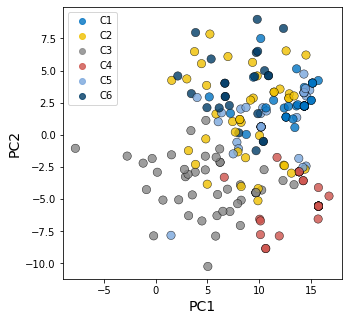

In [13]:
fig,ax = plt.subplots(figsize=(5,5))

pl.plot_scatter(meta_df, 'consensus_nmf', ax, pal=pl.COLORMAP2)
ax.legend(loc='upper left')
ax.set_title("")
plt.savefig(os.path.join(PLOTS_DIR, "figS1c_bmf_consensus_k6_pca.pdf"), dpi=100, bbox_inches='tight')

In [14]:
meta_df = meta_df.join(H['max_id'])

# Save Sample-Cluster mapping
meta_df.rename(columns={
    'max_id':'binary_nmf',
}).to_csv(os.path.join(SUPP_DIR, "table4_sample_cluster_id.tsv"),sep='\t')

---
## 5. Fisher Exact Test for Consensus Clusters

In [ ]:
groupby = 'consensus_nmf'
adj_pval_thresh = 0.1

In [15]:
meta_df = pd.read_csv(os.path.join(SUPP_DIR, "table2_cohort_metadata.tsv"), sep='\t',index_col=0)
X_filt = pd.read_csv(os.path.join(SUPP_DIR, "table3_smm_filt_matrix.tsv"), sep='\t', index_col=0)
clust_df = pd.read_csv(os.path.join(SUPP_DIR, "table4_sample_cluster_id.tsv"), sep='\t',index_col=0)

In [20]:
# Run Fisher Exact
fe_df = smm.fisher_exact(X_filt, clust_df, groupby).reset_index()

# Save results
fe_df.to_csv(os.path.join(SUPP_DIR, "table5_consensus_bmf_fe.tsv"), sep='\t')

In [25]:
print("Significant features per cluster\n------")
for c in np.sort(list(set(fe_df.consensus_nmf))):
    print("{} --> {}".format(c, ', '.join(fe_df[(fe_df['consensus_nmf']==c) & (fe_df['pval_adj']<adj_pval_thresh)].feat.values)))

Significant features per cluster
------
C1 --> NRAS, TRAF3, MAX
C2 --> NRAS, BRAF, TP53, ATM, DIS3, LTB, NFKB2, DUSP2, MAFB, KMT2C, 6q_del, 17p_del, 16q_del, del_4q, 1p_del, del_20q, del_18q, t(14;20)
C3 --> BRAF, ATM, DIS3, ZNF292, EGR1, HIST1H1E, MAF, SETD2, PRKD2, 6q_del, 17p_del, 12p_del, 14q_del, del_4q, 1p_del, del_8p, del_22q, del_20q, del_10p, amp_9_isolated, t(14;16), t(4;14)
C4 --> amp_11_isolated, t(11;14)
C5 --> KRAS, NFKBIA
C6 --> NFKB2, KLHL6, 2p_amp


In [26]:
# Select top feature per clust for heatmap
fe_df_filt = fe_df.sort_values('pval_adj').drop_duplicates('feat', keep='first').sort_values([groupby,'pval_adj']).set_index("feat")
fe_df_filt = fe_df_filt[fe_df_filt['pval_adj'] < adj_pval_thresh]

In [28]:
import scipy.cluster.hierarchy as shc

In [29]:
order_x = list()

for clust in np.unique(clust_df['consensus_nmf']):
    _idx = clust_df['consensus_nmf'][clust_df['consensus_nmf']==clust].index
    X = X_filt.loc[_idx].copy()
    
    # Compute initial linkage to grab ordering
    d_linkage = shc.linkage(X)
    dres = shc.dendrogram(d_linkage, no_plot=True)
    order_x += list(X.iloc[list(map(int, dres['ivl']))].index)

In [30]:
rename_rows = {
    '6q_del':'6q Del',
    '17p_del':'17p Del',
    '16q_del':'16q Del',
    '12p_del':'12p Del',
    '14q_del':'14q Del',
    'del_4q':'4q Del',
    '1p_del':'1p Del',
    'del_8p':'8p Del',
    'del_22q':'22q Del',
    'del_20q':'20q Del',
    'del_10p':'10p Del',
    'del_18q':'18q Del',
    '13q del':'13q Del',
    '8q24 amp':'8q24 Amp',
    'amp_11_isolated':'11 Isolated Amp',
    'amp_9_isolated':'9 Isolated Amp',
    '2p_amp':'2p Amp',
    '1q_gain':'1q Amp'
}

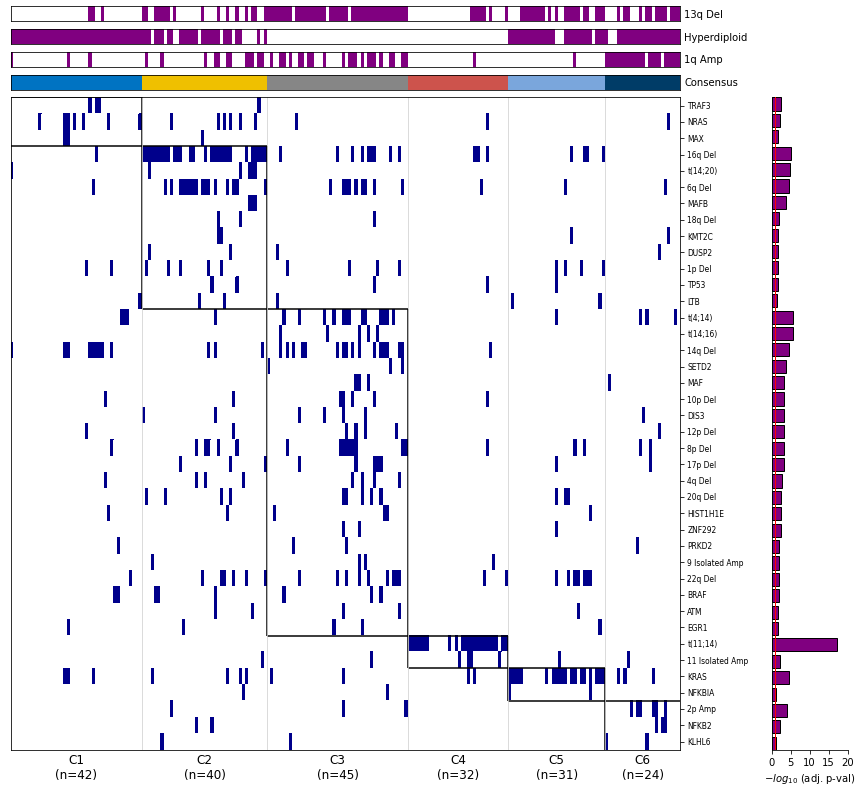

In [50]:
_clust = clust_df['consensus_nmf']
_clust.name = "Consensus"
_t1114 = X_filt['t(11;14)']
_hrd = X_filt['HRD']
_hrd.name = 'Hyperdiploid'
_1q = X_filt['1q_gain']
_1q.name = "1q Amp"
_13q_del = X_filt['13q del']
_13q_del.name = "13q Del"

_ = pl.plot_marker_heatmap_fig1(
    X_filt.rename(columns=rename_rows).T,
    fe_df_filt.rename(index=rename_rows),
    clust_df['consensus_nmf'],
    signatures_idx='consensus_nmf',
    figsize=(12,12),
    metas=[clust_df['consensus_nmf'], _1q, _hrd, _13q_del],
    order_x=order_x
)
plt.savefig(os.path.join(PLOTS_DIR, "fig1b_heatmap.pdf"), dpi=200, bbox_inches='tight')

---

## 6. Misc. Analyses

* Fisher exact test for high risk clusters & for hyperdiploidy (HP) clusters

In [51]:
meta_df = pd.read_csv(os.path.join(SUPP_DIR, "table2_cohort_metadata.tsv"), sep='\t',index_col=0)
X_filt = pd.read_csv(os.path.join(SUPP_DIR, "table3_smm_filt_matrix.tsv"), sep='\t', index_col=0)
clust_df = pd.read_csv(os.path.join(SUPP_DIR, "table4_sample_cluster_id.tsv"), sep='\t',index_col=0)

In [53]:
clust_df['high_risk_clust'] = clust_df['consensus_nmf'].isin(["C2","C3","C5"])
clust_df['hp_clust'] = clust_df['consensus_nmf'].isin(["C1","C2","C5","C6"])

In [54]:
# Run Fisher Exact
fe_df = smm.fisher_exact(X_filt, clust_df, "high_risk_clust").reset_index()

# Save results
fe_df.to_csv(os.path.join(SUPP_DIR, "table6_highrisk_clust_fe.tsv"), sep='\t')

In [58]:
# Run Fisher Exact
fe_df = smm.fisher_exact(X_filt, clust_df, "hp_clust").reset_index()

# Save results
fe_df.to_csv(os.path.join(SUPP_DIR, "table7_hp_clust_fe.tsv"), sep='\t')